Avant de lancer ce NB, je lance le terminal Anaconda et je copie colle : 
mlflow server --host 127.0.0.1 --port 8080 

Ca lance MLFlow

Pour ce projet, nous avons suivi le schéma présenté dans cet article:
https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420

## 1.1 - Imports


In [1]:
import mlflow
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from mlflow.models import infer_signature
from lightgbm import early_stopping

import shap
# Memory management
import gc 

In [2]:
# démarrage du tracking
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [3]:
train_reduced=pd.read_csv('train_reduced.csv')

In [4]:
train_reduced.head()

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR
0,0.083037,0.060749,0.262949,0.139376,-637.0,9461,175783.73,24700.5,-103.0,780.0,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,True,100002
1,0.311267,0.027598,0.622246,NaN,-1188.0,16765,1154108.20,35698.5,-606.0,1216.0,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,False,100003
2,NaN,0.050000,0.555912,0.729567,-225.0,19046,16071.75,6750.0,-408.0,-382.0,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,False,100004
3,NaN,0.094941,0.650442,NaN,-3039.0,19005,994476.70,29686.5,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,100006
4,NaN,0.042623,0.322738,NaN,-3038.0,19932,483756.38,21865.5,-1149.0,-783.0,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,False,100007


In [5]:
train_reduced.shape

(307511, 349)

In [6]:
train_reduced=train_reduced.drop(['AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_TERM'], axis=1)

In [7]:
train_reduced.shape

(307511, 346)

# 5 - Nouvelle modélisation LGBM avec features = 95% de l'importance

In [8]:
def prepare_modelisation (full_train) :

    # split train/test
    train, test = train_test_split(full_train, test_size=0.2, random_state=42)

    # Extraire les identifiants, les cibles et les caractéristiques pour les ensembles d'entraînement et de test
    X_train = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    y_train = train['TARGET']
    id_train = train['SK_ID_CURR']

    X_test = test.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    y_test = test['TARGET']
    id_test = test['SK_ID_CURR']
    
    # Create a label encoder object
    le = LabelEncoder()
    
    # Iterate through the columns and label encode if object type and nunique <=2
    for col in X_train.columns:
        if X_train[col].dtype == 'object' and len(list(X_train[col].unique())) <= 2:
            # Apply the label encoder to both training and test sets
            X_train[col] = le.fit_transform(X_train[col])
            X_test[col] = le.transform(X_test[col])

               
    # one-hot encoding of categorical variables
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    # Assurons-nous que X_train et X_test ont les mêmes colonnes
    X_train, X_test = X_train.align(X_test, join='inner', axis=1)
    
   
    # Median imputation of missing values
    imputer = SimpleImputer(strategy = 'median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))

    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

   
    return X_train, X_test, y_train, y_test, id_train, id_test

In [9]:
X_train_r, X_test_r, y_train_r, y_test_r, id_train_r, id_test_r=prepare_modelisation (train_reduced)

In [10]:
X_train_r.shape, X_test_r.shape, y_train_r.shape, y_test_r.shape, id_train_r.shape, id_test_r.shape

((246008, 344), (61503, 344), (246008,), (61503,), (246008,), (61503,))

# **FONCTION DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

In [11]:
def custom_f1(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_f1 = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_f1 = f1
            best_threshold = threshold
            best_cost = cost
    
    return best_f1

In [12]:


def custom_recall(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_recall = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_recall = recall
            best_threshold = threshold
            best_cost = cost
    
    return best_recall

In [13]:
# Fonction pour run la grid search. J'y ajoute le fit_params dans le quel j'ajouterai l'early stopping pour le lgbm

def run_grid_search(X_train, y_train, model, param_grid, fit_params=None, train_size=1.0):
    # Définir les scorers personnalisés
    scorers = {
        'AUC': 'roc_auc',
        'F1_opt': make_scorer(custom_f1, needs_proba=True),
        'recall_opt': make_scorer(custom_recall, needs_proba=True)
    }

    # Créer un pipeline avec SMOTE et le modèle
    pipeline = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Mettre à jour le param_grid pour correspondre au pipeline
    # Les paramètres du modèle doivent être préfixés par 'model__'
    param_grid = {f'model__{key}': value for key, value in param_grid.items()}

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='AUC',
        cv=2,
        verbose=3,
        return_train_score=True
    )

     # Fractionnement des données si train_size < 1.0
    if train_size < 1.0:
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
        data_to_fit = (X_train_sample, y_train_sample)
    else:
        data_to_fit = (X_train, y_train)

    # Entraînement
    start_time = time.time()
    grid_search.fit(*data_to_fit)
    end_time = time.time()

    execution_time = round(end_time - start_time, 2)
    print(f"Le temps d'execution est de {execution_time} secondes.")

    return {
        'best_model' : grid_search.best_estimator_,
        'best_params_': grid_search.best_params_,
        'best_score_': grid_search.best_score_,
        'cv_results_': grid_search.cv_results_
    }

In [14]:
def extract_best_auc_result(results):
    """
    Extracts the best model configuration based on AUC score from the cv_results of a GridSearchCV.
    
    Parameters:
    - results (dict): A dictionary output from the run_grid_search function containing 'cv_results_'.
    
    Returns:
    - DataFrame: A DataFrame containing the best scoring row based on the AUC rank.
    """
    # Conversion of cv_results_ into a DataFrame
    cv_results = results['cv_results_']
    df_cv_results = pd.DataFrame(cv_results)
    
    # Sorting the DataFrame by the rank of the AUC test scores
    df_cv_results = df_cv_results.sort_values(by="rank_test_AUC", ascending=True)
    
    # Returning the top entry
    return df_cv_results.head(1)

In [15]:
def plot_auc_scores(best_auc_result):
    """
    Plots the AUC scores from cross-validation folds for the best model configuration based on rank.
    
    Parameters:
    - best_auc_result (DataFrame): A DataFrame with the top row from cv_results_ sorted by AUC.
    - full_cv_results (DataFrame): The full cv_results DataFrame to extract mean scores for rank 1.
    """
    # Extract the AUC scores for each fold for the best AUC configuration
    df_train_results_auc = best_auc_result[[
        'split0_train_AUC', 
        'split1_train_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    df_test_results_auc = best_auc_result[[
        'split0_test_AUC', 
        'split1_test_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot the train scores
    ax.plot(range(0, 2), df_test_results_auc.reshape(-1), label='Scores de validation')
    
    # Plot the test scores
    ax.plot(range(0, 2), df_train_results_auc.reshape(-1), label='Scores de train')

    # # Plot the average for the combinations with rank_test_AUC == 1
    # mean_scores_rank_1 = best_auc_result.loc[best_auc_result['rank_test_AUC'] == 1, 'mean_test_AUC']
    # ax.axhline(y=mean_scores_rank_1.values[0], color='g', linestyle='--', label='Moyenne (rank 1)')
    
    # Set the properties of the axis
    ax.set_xticks(range(0, 2))
    ax.set_xlabel("Folds de cross-validation")
    ax.set_ylabel('AUC')
    ax.set_title("AUC de chaque fold \n pour la combinaison d'hyperparamètres \n qui arrive au rang 1 en terme d'AUC", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")
    
    # Add a legend
    ax.legend()

    fig.tight_layout()
    
    plt.show()


In [16]:
# fonction qui va établir un seuil pour convertir les probabiliiéts en étiquettes de classe binaire. 
# à partir de la matrice de confusion, on va calculer le coût

def calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp):
    y_pred = (probas >= threshold).astype(int) # transforme les probas en prédictions binaires en utilisant un seuil. 
                                                # Les probabilités >= au seuil sont marquées comme 1 (positives),
                                                # les autres comme 0 (négatives).

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() # .ravel() convertit la matrice 2x2 en un tableau à une dimension [tn, fp, fn, tp]
                                                            # permet une extraction facile de chaque valeur
    return cost_fn * fn + cost_fp * fp

In [17]:
def evaluate_model (X_train, y_train, X_test, y_test, best_model):

    start_predict_time = time.time()
    # Predict on the training data
    y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    
    # Predict on the test data
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    end_predict_time = time.time()

    # Calculate AUC for training and test data
    auc_train = round(roc_auc_score(y_train, y_train_pred_proba),2)
    auc_test = round(roc_auc_score(y_test, y_test_pred_proba),2)

    # Find the optimal threshold for cost function on the training data
    thresholds = np.linspace(0, 1, 100)
    costs = [calculate_cost_threshold(y_test, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
    optimal_threshold = round(thresholds[np.argmin(costs)],2) 

    # Metrics at the optimal threshold
    y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)
    
    f1_score_1_test = f1_score(y_test, y_test_pred_opt)
    recall_1_test = recall_score(y_test, y_test_pred_opt)
    accuracy_test = accuracy_score(y_test, y_test_pred_opt)
    
    return {
        'predicting_execution_time': round(end_predict_time - start_predict_time, 2),
        'auc_train': auc_train,
        'auc_test': auc_test,
        'optimal_threshold': optimal_threshold,
        'f1_score_1_test': round(f1_score_1_test,2),
        'recall_1_test': round(recall_1_test,2),
        'accuracy_test': round(accuracy_test,2)
    }

In [18]:
def show_feature_importances(importances, features):
    # Création du DataFrame

    importances = importances.flatten()
    
    feature_importances = pd.DataFrame({
        'feature': features, 
        'importance': importances
    })
    
    # Tri et sélection des 20 caractéristiques les plus importantes
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_importances_sorted = feature_importances_sorted.head(20)
    
    # Normalisation des importances
    feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()
    
    # Création du graphique à barres horizontales
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    # Inversion de l'index pour afficher la plus importante en haut
    indices = list(reversed(list(feature_importances_sorted.index)))
    ax.barh(indices, feature_importances_sorted['importance_normalized'], align='center', edgecolor='k')
    
    # Définition des étiquettes y
    ax.set_yticks(indices)
    ax.set_yticklabels(feature_importances_sorted['feature'])
    
    # Étiquetage du graphique
    plt.xlabel('Normalized Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()
    
    return feature_importances_sorted

# Exemple d'utilisation
# importances = [valeur1, valeur2, ..., valeurN] # remplacez par vos valeurs d'importance réelles
# features = ['nom1', 'nom2', ..., 'nomN'] # remplacez par vos noms de caractéristiques réels
# feature_importances_sorted = plot_feature_importances(importances, features)


# **FIN DES FONCTIONS DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

In [19]:
model_LGBM_2 = lgb.LGBMClassifier(objective='binary',
                                boosting_type = 'goss',
                                # class_weight = 'balanced',
                                random_state = 50)
        
param_grid_LGBM_2 = {
    'num_leaves': [35,40],
    'n_estimators' : [150,200],   
    'learning_rate' : [0.07, 0.1],
}

# Paramètres pour early_stopping
fit_params = {
    'eval_metric': 'auc',
    'callbacks':[early_stopping(stopping_rounds=50)]
}

In [20]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM_2 = run_grid_search(X_train_r, y_train_r, model_LGBM_2, param_grid_LGBM_2,fit_params)

end_training_time = time.time()

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 113066, number of negative: 113066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.371212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87435
[LightGBM] [Info] Number of data points in the train set: 226132, number of used features: 344
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore

In [21]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 389.04 secondes.


In [22]:
best_model_lgbm_2 = results_LGBM_2['best_model']
best_params_lgbm_2 = results_LGBM_2['best_params_']
best_score_lgbm_2 = results_LGBM_2['best_score_']
cv_results_lgbm_2 = results_LGBM_2['cv_results_']

print("Best Params:", best_params_lgbm_2)
print("Best AUC:", best_score_lgbm_2)

Best Params: {'model__learning_rate': 0.07, 'model__n_estimators': 200, 'model__num_leaves': 40}
Best AUC: 0.7647839072310056


In [23]:
best_auc_result_LGBM_2 = extract_best_auc_result(results_LGBM_2)
best_auc_result_LGBM_2.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_model__num_leaves,params,split0_test_AUC,split1_test_AUC,...,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
3,15.045089,0.52618,4.381229,0.167467,0.07,200,40,"{'model__learning_rate': 0.07, 'model__n_estim...",0.763732,0.765835,...,0.009518,0.67901,0.64027,0.65964,0.01937,4,0.742302,0.775408,0.758855,0.016553


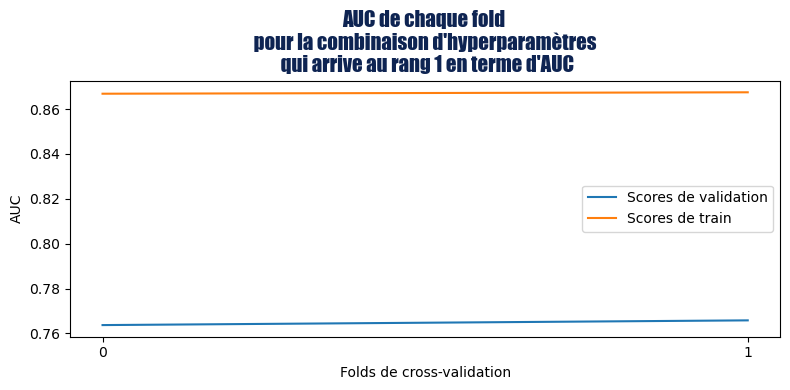

In [24]:
plot_auc_scores(best_auc_result_LGBM_2)

In [25]:
result_lgbm_2=evaluate_model (X_train_r, y_train_r, X_test_r, y_test_r, best_model_lgbm_2)
result_lgbm_2

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


{'predicting_execution_time': 1.22,
 'auc_train': 0.82,
 'auc_test': 0.77,
 'optimal_threshold': 0.09,
 'f1_score_1_test': 0.28,
 'recall_1_test': 0.69,
 'accuracy_test': 0.71}

In [71]:
# Création d'une nouvelle expérience MLflow
mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# Commencer une session MLflow
with mlflow.start_run():
    # Log les hyperparameters que j'ai déclarés au dessus
    mlflow.log_params(best_params_lgbm_2)

    # Log les métriques
    
    mlflow.log_metric("optimal_threshold", result_lgbm_2['optimal_threshold'])

    mlflow.log_metric("recall_1_test", result_lgbm_2['recall_1_test'])
    mlflow.log_metric("f1_score_1_test", result_lgbm_2['f1_score_1_test'])
    mlflow.log_metric("accuracy du test", result_lgbm_2['accuracy_test'])
    
    mlflow.log_metric("auc_train", result_lgbm_2['auc_train'])
    mlflow.log_metric("auc_test", result_lgbm_2['auc_test'])
    
    mlflow.log_metric("temps_fit", training_execution_time)
    mlflow.log_metric("temps_predict", result_lgbm_2['predicting_execution_time'])

    
 
    

    # Définir un tag pour se rappeler l'objet de cette session
    mlflow.set_tag("Training Info", "LGBM with 303 features")

    # Infer the model signature
    signature = infer_signature(X_train_r, best_model_lgbm_2.predict(X_train_r)) # infer_signature génère automatiquement une "signature" 
                                                              # qui décrit les entrées et les sorties du modèle. 
                                                              # Cela inclut les types de données et les formats attendus par le modèle, 
                                                              # facilitant ainsi l'intégration et la réutilisation du modèle 
                                                              # dans différents environnements.

    
    # Log le model
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model_lgbm_2.named_steps['model'], # le modèle
        artifact_path="lgbm_classifier_model", # le chemin où le modèle sera enregistré
        signature=signature, # la signature du modèle
        input_example=X_train_r, # un exemple d'input pour montrer comment invoquer le modèle
        registered_model_name="scoring-credit-lgbm_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
    )


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


MlflowException: API request to http://127.0.0.1:8080/api/2.0/mlflow-artifacts/artifacts/584662401003945009/916bd3f15715481ba8f095fa82449229/artifacts/lgbm_classifier_model/input_example.json failed with exception HTTPConnectionPool(host='127.0.0.1', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/584662401003945009/916bd3f15715481ba8f095fa82449229/artifacts/lgbm_classifier_model/input_example.json (Caused by ProtocolError('Connection aborted.', ConnectionResetError(10054, 'Une connexion existante a dû être fermée par l’hôte distant', None, 10054, None)))

# 8 - Interprétation des résultats

## 8.1 - Feature Importance

In [27]:
importances = best_model_lgbm_2.named_steps['model'].feature_importances_
features= X_train_r.columns

In [28]:
importances

array([164, 186, 198,  77, 104, 104,  58,  61,  37,  64,  33,  51,  35,
        29,  30,  44,  30,  72,  88,  16,  20,  54,  24,  15,  24,  23,
        63,  36,  21,  32,  23,  43,  11,  15,  39,  26,  23,  15,  27,
        12,  35,  18,  37,  13,  20,  11,  15,  36,  19, 185,  15,  42,
        22,  46,  14,  12,   4,  13,  12,  29,  31,  12,   7,  14,  10,
         6,  36,  35, 118,  14,  10,  15,  12,  67,  12,  11,  10,   6,
        10,   8,  13,  30, 115,  41,  44,  28,  10,   8,  11,   8,  35,
        19,  15,  16,  23,  13,  20,  14,   8,  44, 119,   8,   1,  16,
        92,   9,  16,  10,  12,   7,  11,  26,  11,   4,   7,   6,   5,
         4,   9,  31,  16,   7,  11,  19,  28, 175,  11,  25,   6,  13,
         7,  50,  41,   8,   4,   7,  95, 114,   5,  20,   6,   7,  38,
        17,   8,   7,   9,   3,  13,  60,   5,   8,   7,  16,  41,   5,
         7,   6,   5,   6,  13,  40,  11,   4,  11,  52,   8,   8,   5,
        11,  10,  25,  20,  24,   3,   3,  14,  10,   9,   5,   

In [29]:
X_train_r.head(1)

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,client_bureau_balance_STATUS_1_count_mean,ORGANIZATION_TYPE_Bank,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers
0,0.544382,0.419378,0.629055,0.908106,0.894025,0.098148,0.795003,0.583347,0.312084,0.340659,...,0.007576,0.0,0.0,0.004319,0.0,0.047359,0.0,0.0,0.0,0.0


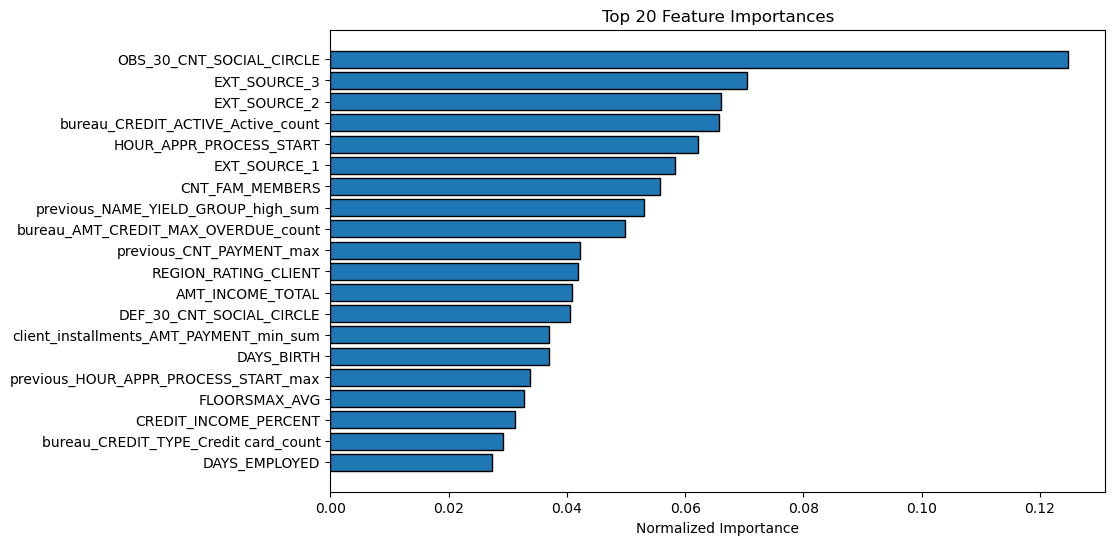

,feature,importance,importance_normalized
0,OBS_30_CNT_SOCIAL_CIRCLE,351,0.124778
1,EXT_SOURCE_3,198,0.070387
2,EXT_SOURCE_2,186,0.066122
3,bureau_CREDIT_ACTIVE_Active_count,185,0.065766
4,HOUR_APPR_PROCESS_START,175,0.062211
5,EXT_SOURCE_1,164,0.058301
6,CNT_FAM_MEMBERS,157,0.055812
7,previous_NAME_YIELD_GROUP_high_sum,149,0.052968
8,bureau_AMT_CREDIT_MAX_OVERDUE_count,140,0.049769
9,previous_CNT_PAYMENT_max,119,0.042304


In [30]:
show_feature_importances(importances, features)

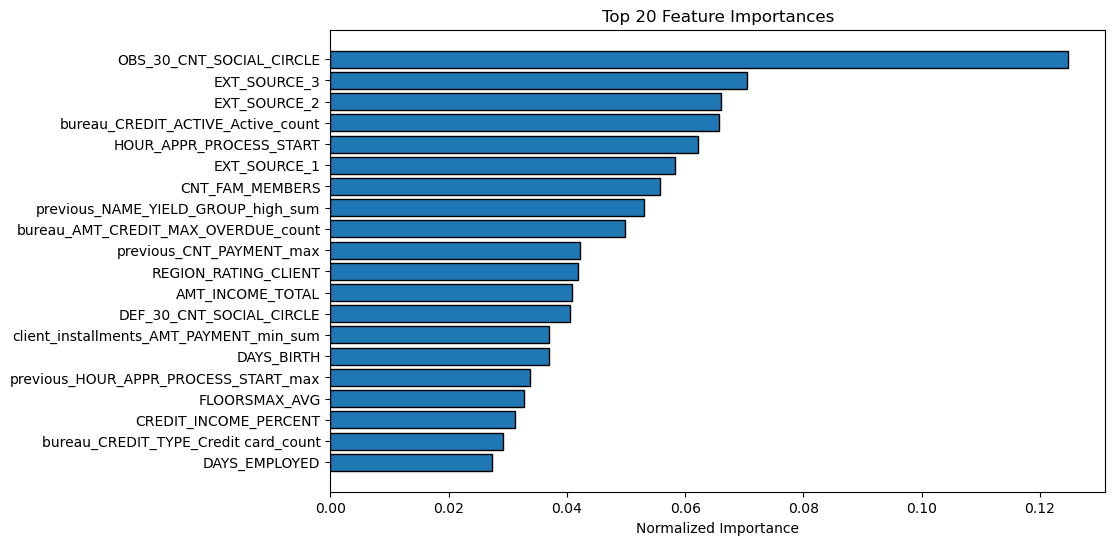

In [31]:
feature_importances_sorted=show_feature_importances(importances, features)

In [32]:
feature_importances_sorted

,feature,importance,importance_normalized
0,OBS_30_CNT_SOCIAL_CIRCLE,351,0.124778
1,EXT_SOURCE_3,198,0.070387
2,EXT_SOURCE_2,186,0.066122
3,bureau_CREDIT_ACTIVE_Active_count,185,0.065766
4,HOUR_APPR_PROCESS_START,175,0.062211
5,EXT_SOURCE_1,164,0.058301
6,CNT_FAM_MEMBERS,157,0.055812
7,previous_NAME_YIELD_GROUP_high_sum,149,0.052968
8,bureau_AMT_CREDIT_MAX_OVERDUE_count,140,0.049769
9,previous_CNT_PAYMENT_max,119,0.042304


In [33]:
feature_importances_sorted.to_csv('feature_importances_sorted_lgbm_3.csv', index=False)

## 8.2 - Shap Values

### 8.2.1 - Interprétation globale du test

In [34]:
# on s'assure que le meilleur modèle est extrait de la pipeline
best_model=best_model_lgbm_2.named_steps['model']

In [35]:
# # Comme le SMOTE est appliqué dans le pipeline, nous devons transformer les données X_test_r avant d'appliquer SHAP
# # Pour cela, nous utilisons le transformateur dans le pipeline avant le modèle
# data_for_shap = results_LGBM_2['best_model'].named_steps['sampling'].fit_resample(X_test_r, y_test_r)

In [36]:
# # Extraction des données transformées qui sont maintenant suréchantillonnées
# X_test_resampled, y_test_resampled = data_for_shap

In [37]:
# Initialisation de l'Explainer SHAP avec le meilleur modèle obtenu sur le jeu de données de test original
explainer = shap.Explainer(best_model)

In [38]:
# Calcul des valeurs SHAP sur les données de test
shap_values = explainer.shap_values(X_test_r)

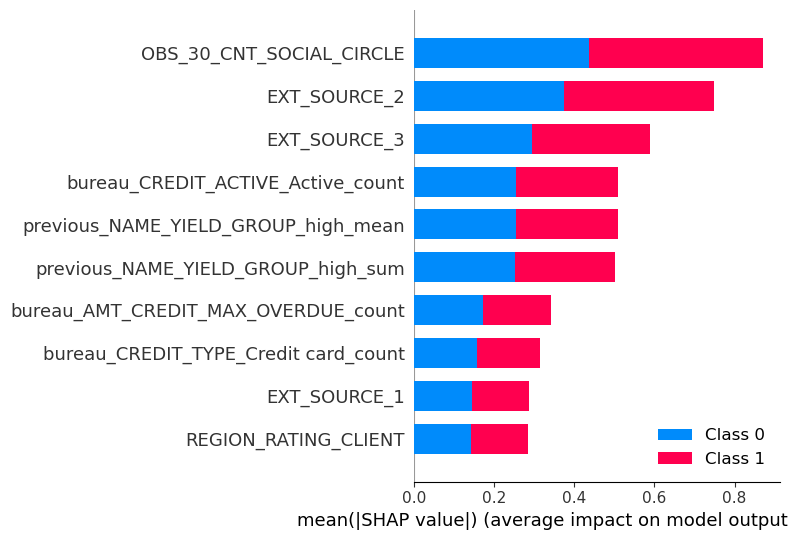

In [39]:
# Créer un graphique récapitulatif SHAP pour l'ensemble des données transformées
shap.summary_plot(shap_values, X_test_r, 
                  plot_type="bar",
                 max_display=10)

Si on regarde ce qui se passe pour la classe 1 :

In [40]:
shap_values_class1 = shap_values[1]

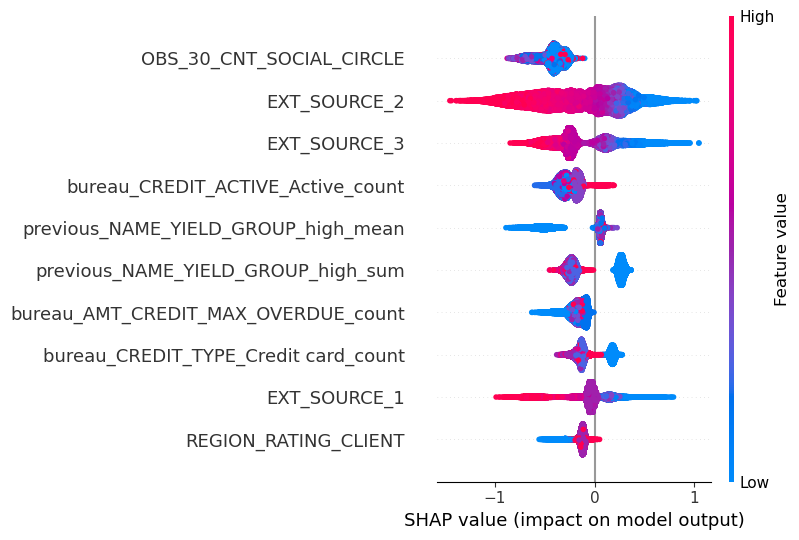

In [41]:
# Graphique récapitulatif SHAP pour la classe 1
shap.summary_plot(shap_values_class1, 
                  X_test_r, 
                  max_display=10)

### 8.2.2 - Interprétation locale

#### 8.2.2.1 - Reconstruction du test

In [42]:
id_test_r.head()

245895    384575
98194     214010
36463     142232
249923    389171
158389    283617
Name: SK_ID_CURR, dtype: int64

In [43]:
X_test_r.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,client_bureau_balance_STATUS_1_count_mean,ORGANIZATION_TYPE_Bank,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers
0,0.705732,0.707479,0.000000,0.957459,0.327396,0.004421,0.955852,0.576120,0.073171,0.208791,...,0.012987,0.0,0.000000,0.000000,0.0,0.006084,0.0,0.0,0.00,0.0
1,0.444220,0.497486,0.794687,0.936300,0.410879,0.197013,0.899042,0.702708,0.093496,0.120879,...,0.000000,0.0,0.028933,0.000463,0.0,0.010647,0.0,0.0,0.00,0.0
2,0.547108,0.621942,0.231648,0.964326,0.587260,0.011368,0.863450,0.589233,0.060976,0.043956,...,0.010101,0.0,0.000000,0.000000,0.0,0.006084,0.0,0.0,0.00,0.0
3,0.524898,0.811136,0.685538,0.610205,0.684160,0.000034,0.252225,0.545527,0.038049,0.098901,...,0.000000,0.0,0.000000,0.000000,0.0,0.006084,0.0,0.0,0.00,0.0
4,0.683325,0.655778,0.710063,0.938310,0.723675,0.014431,0.925736,0.594982,0.100610,0.098901,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.36,0.0


In [44]:
y_test_r.head()

245895    False
98194     False
36463     False
249923    False
158389    False
Name: TARGET, dtype: bool

In [45]:
# verif
train_reduced[train_reduced['SK_ID_CURR']==100002]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR
0,0.083037,0.262949,0.139376,-637.0,9461,175783.73,-103.0,780.0,15.0,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,True,100002


In [46]:
# reconstruction du test
test_dataset = pd.concat([X_test_r, y_test_r.reset_index(drop=True), id_test_r.reset_index(drop=True)], axis=1)
# verif
test_dataset[test_dataset['SK_ID_CURR']==100002]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR
17677,0.073068,0.307542,0.155054,0.964437,0.111161,0.025738,0.96475,0.583634,0.182927,0.098901,...,0.0,0.0,0.0,0.006084,0.0,0.0,0.0,0.0,True,100002


In [47]:
# predict proba avec le best model
y_test_pred_proba = best_model_lgbm_2.predict_proba(X_test_r)[:, 1]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [48]:
# Find the optimal threshold for cost function on the training data
thresholds = np.linspace(0, 1, 100)
costs = [calculate_cost_threshold(y_test_r, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
optimal_threshold = round(thresholds[np.argmin(costs)],2) 

# Metrics at the optimal threshold
y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)

In [49]:
test_dataset['target_pred']=y_test_pred_opt
test_dataset['proba']=y_test_pred_proba

test_dataset[test_dataset['SK_ID_CURR']==100002]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR,target_pred,proba
17677,0.073068,0.307542,0.155054,0.964437,0.111161,0.025738,0.96475,0.583634,0.182927,0.098901,...,0.0,0.006084,0.0,0.0,0.0,0.0,True,100002,1,0.286929


In [50]:
pd.crosstab(y_test_r, y_test_pred_opt, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
False,40143,16411
True,1514,3435


In [51]:
print(classification_report(y_test_r, y_test_pred_opt))

              precision    recall  f1-score   support

       False       0.96      0.71      0.82     56554
        True       0.17      0.69      0.28      4949

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.77     61503



#### 8.2.2.2 - Interprétation d'un individu prédit en classe 1

In [52]:
test_dataset[test_dataset['target_pred']==1].head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR,target_pred,proba
0,0.705732,0.707479,0.000000,0.957459,0.327396,0.004421,0.955852,0.576120,0.073171,0.208791,...,0.0,0.006084,0.0,0.0,0.0,0.0,False,384575,1,0.220546
2,0.547108,0.621942,0.231648,0.964326,0.587260,0.011368,0.863450,0.589233,0.060976,0.043956,...,0.0,0.006084,0.0,0.0,0.0,0.0,False,142232,1,0.222253
5,0.524898,0.607166,0.116437,0.908106,0.656201,0.054768,0.947296,0.575846,0.213415,0.098901,...,0.0,0.006084,0.0,0.0,0.0,0.0,False,362171,1,0.164039
7,0.524898,0.014722,0.546890,0.985485,0.186697,0.022055,0.809377,0.585332,0.109756,0.131868,...,0.0,0.006084,0.0,0.0,0.0,0.0,False,310328,1,0.369996
12,0.524898,0.672122,0.201412,0.908106,0.847971,0.006401,0.982546,0.585195,0.371951,0.098901,...,0.0,0.015344,0.0,0.0,0.0,0.0,False,188909,1,0.314531


In [53]:
test_dataset[test_dataset['SK_ID_CURR']==384575]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR,target_pred,proba
0,0.705732,0.707479,0.0,0.957459,0.327396,0.004421,0.955852,0.57612,0.073171,0.208791,...,0.0,0.006084,0.0,0.0,0.0,0.0,False,384575,1,0.220546


In [54]:
specific_id = 384575
index=test_dataset[test_dataset['SK_ID_CURR']==specific_id].index[0]

In [55]:
individual_shap_values = shap_values[1][index]  # Choix de la classe positive 

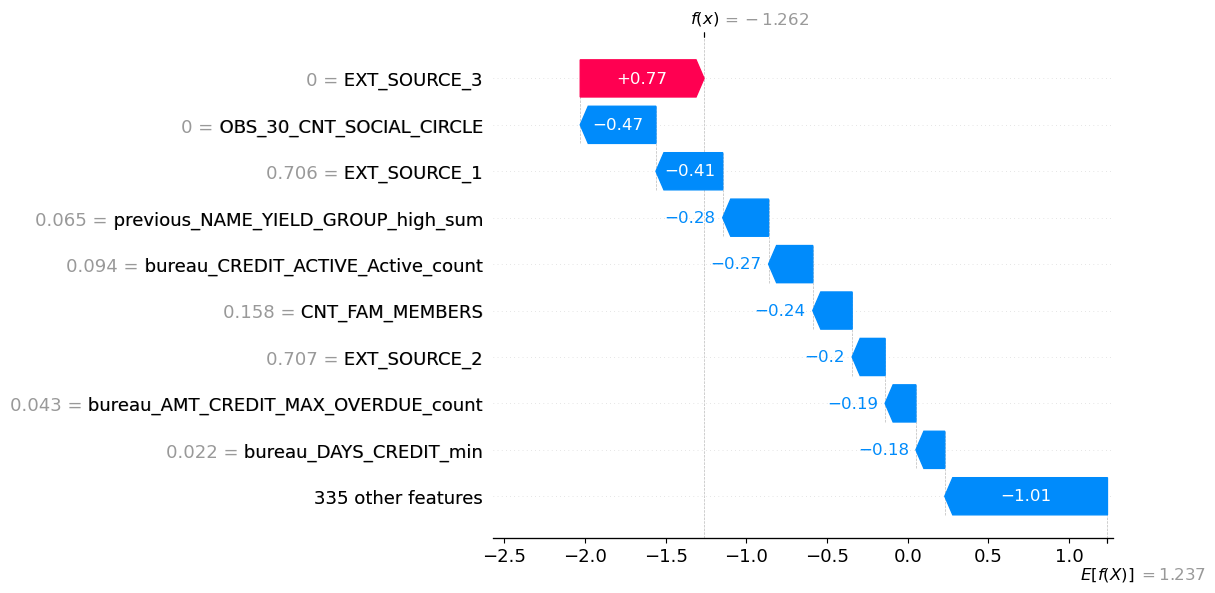

In [56]:
# Créer le graphique waterfall pour cet individu
shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                      base_values=explainer.expected_value[1], # Assurez-vous de choisir la bonne valeur de base
                                      data=X_test_r.iloc[index],         # Données de l'individu à l'index 0
                                      feature_names=X_test_r.columns.tolist())) # Noms des caractéristiques



#### 8.2.2.3 - Interprétation d'un individu prédit en classe 0

In [57]:
test_dataset[test_dataset['target_pred']==0].head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR,target_pred,proba
1,0.444220,0.497486,0.794687,0.936300,0.410879,0.197013,0.899042,0.702708,0.093496,0.120879,...,0.0,0.010647,0.0,0.0,0.00,0.0,False,214010,0,0.053747
3,0.524898,0.811136,0.685538,0.610205,0.684160,0.000034,0.252225,0.545527,0.038049,0.098901,...,0.0,0.006084,0.0,0.0,0.00,0.0,False,389171,0,0.037807
4,0.683325,0.655778,0.710063,0.938310,0.723675,0.014431,0.925736,0.594982,0.100610,0.098901,...,0.0,0.000000,0.0,0.0,0.36,0.0,False,283617,0,0.070426
6,0.746486,0.640892,0.599166,0.980739,0.464092,0.022055,0.751198,0.564321,0.109756,0.098901,...,0.0,0.006084,0.0,0.0,0.00,0.0,False,180689,0,0.041307
8,0.524898,0.090684,0.706328,0.908106,0.903439,0.111500,0.878850,0.583101,0.189383,0.098901,...,0.0,0.006084,0.0,0.0,0.00,0.0,False,233043,0,0.072432


In [58]:
specific_id = 214010
index=test_dataset[test_dataset['SK_ID_CURR']==specific_id].index[0]

In [59]:
individual_shap_values = shap_values[0][index]  # Choix de la classe positive 

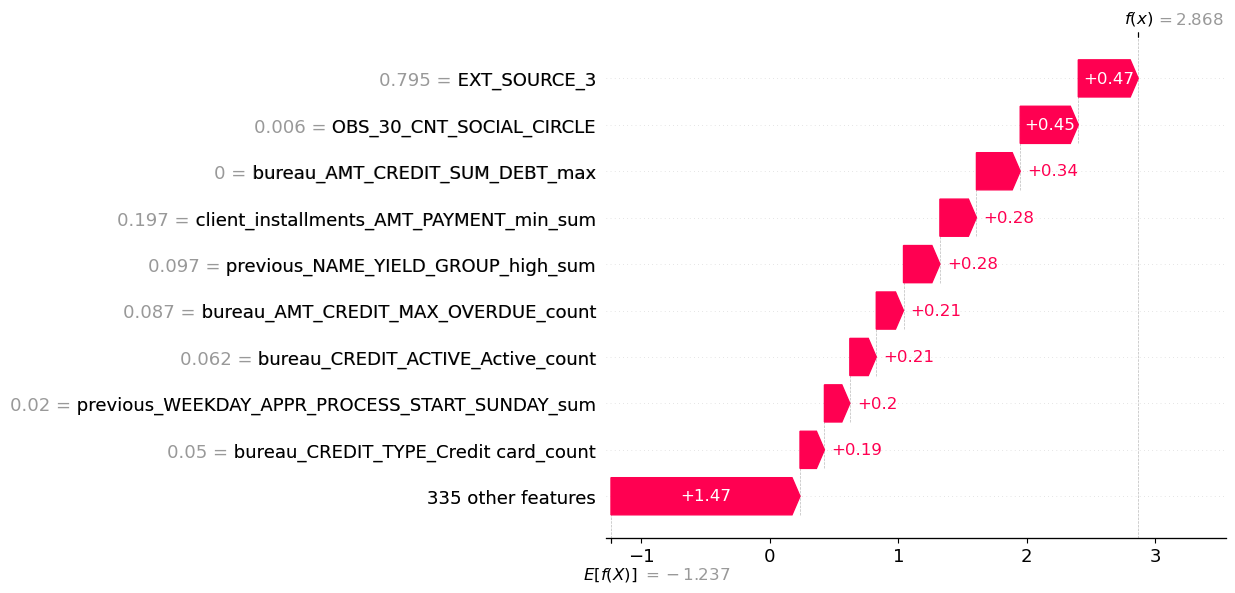

In [60]:
# Créer le graphique waterfall pour cet individu
shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                      base_values=explainer.expected_value[0], # Assurez-vous de choisir la bonne valeur de base
                                      data=X_test_r.iloc[index],         # Données de l'individu à l'index 0
                                      feature_names=X_test_r.columns.tolist())) # Noms des caractéristiques


In [61]:
def generate_shap_waterfall(specific_id, shap_values, test_dataset, explainer, X_r):
    """
    Génère un graphique waterfall SHAP pour un individu spécifié par son ID.

    Parameters:
    - specific_id : int
        L'ID de l'individu pour lequel générer le graphique.
    - shap_values : list of numpy arrays
        Les valeurs SHAP pour les classes, typiquement [shap_values_class0, shap_values_class1].
    - test_dataset : DataFrame
        Le DataFrame contenant les identifiants des individus.
    - explainer : shap.Explainer
        L'explainer SHAP utilisé pour calculer les valeurs SHAP.
    - X_resampled : DataFrame
        Le DataFrame des données transformées (suréchantillonnées) sur lequel les valeurs SHAP ont été calculées.
    """
    # Trouver l'index de l'individu
    index = test_dataset[test_dataset['SK_ID_CURR'] == specific_id].index[0]

    # Prédire la classe pour l'individu
    predicted_class = test_dataset.loc[index, 'target_pred']

    # Obtenir les valeurs SHAP pour la classe prédite
    individual_shap_values = shap_values[predicted_class][index]

    # Création du graphique waterfall
    shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                          base_values=explainer.expected_value[predicted_class],
                                          data=X_r.iloc[index],
                                          feature_names=X_r.columns.tolist()))
    plt.show()


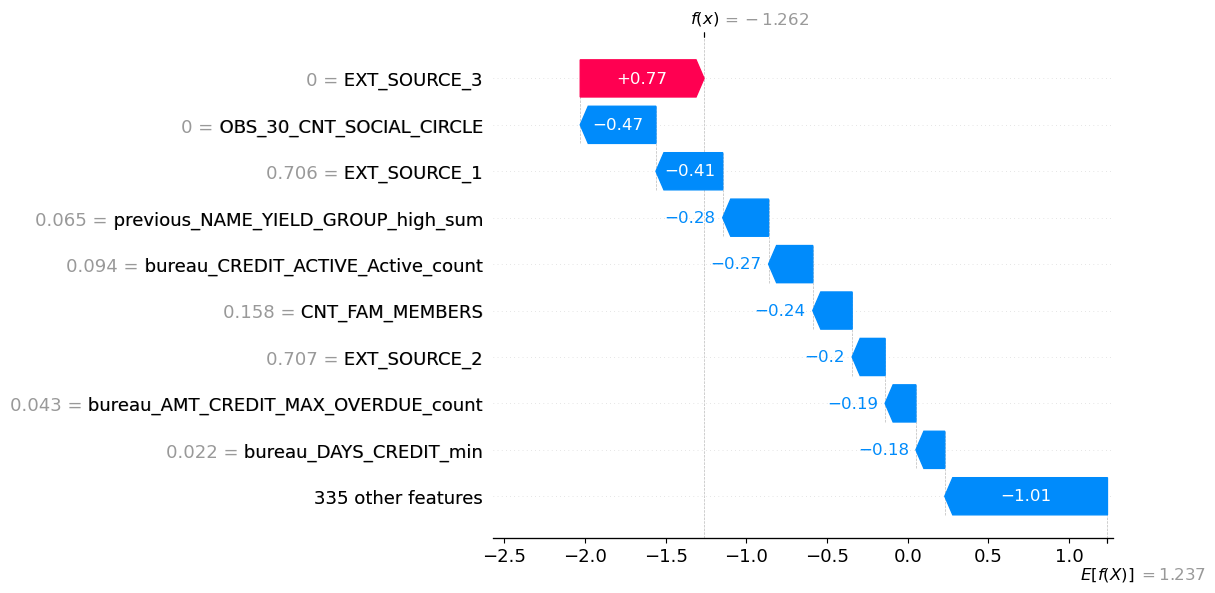

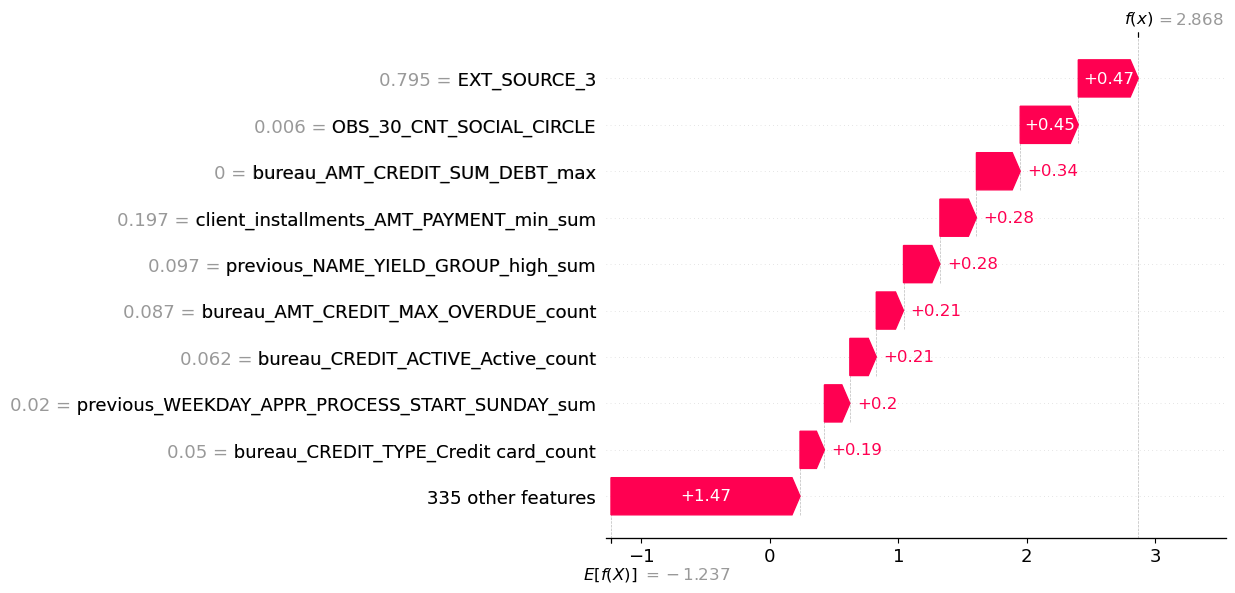

In [62]:
# Pour un individu prédit en classe 1
generate_shap_waterfall(384575, shap_values, test_dataset, explainer, X_test_r)

# Pour un individu prédit en classe 0
generate_shap_waterfall(214010, shap_values, test_dataset, explainer, X_test_r)


CONCLUSION : la suppression des variables AMT_CREDIT, AMT_ANNUITY, CREDIT_TERM n'a pas affecté la performance du modèle

Pour la suite, je me suis basée sur : https://app.livestorm.co/openclassrooms-1/deployez-une-api-de-prediction/live?s=021e19b0-cd31-4872-8b6f-b71209d05664#/chat

# 9 - Sérialisation du modèle

Sérialisation = le fait de convertir un objet qui est stocké de façon numérique sur notre mémoire ram. et le stocker sous forme de binaire sur notre ordiinateur. la pipeline était dans notre mémoire vive. On veut la stocker sous forme de fichier pour pouvoir la réutiliser plus tard

On peut sérialser en pickle ou en joblib. Avec Scikit Learn, on recommande joblib

In [63]:
import joblib

In [64]:
joblib.dump(best_model_lgbm_2, 'credit_scoring.joblib')

['credit_scoring.joblib']

# 10 - Déploiement du modèle avec MLFlow

On va utiliser la fonctionnalité MLFlow Models de MLFlow

On ne peut pas juste déployer la pipeline qu'on a enregistré à l'étape précédente. Il faut passer par le format de stockage de ML Flow. Ils ont établi un standard qui n'est pas très compliqué. Ca passe par la création d'un répertoire mlflow_model qui va contenir 3 choses :
- la description de notre modèle : le fichier MLmodel
- le modèle en lui même : model.pkl
- l'ensemble des dépdenances nécessaires à l'éxécution : conda.yaml

**Format de stockage d'un modèle**
Un modèle MLflow est un répertoire contenant une liste de fichiers, dont un nommé MLmodel qui liste les différentes flavors (terme MLflow) dans lesquelles le modèle est utilisable.

Les flavors sont une façon pratique de définir comment exécuter un modèle, cette convention facilite le déploiement car la flavor standardise la façon de prédire à partir d'un modèle. MLflow définit par exemple des flavors pour une fonction python, sklearn, tensorflow, xgboost.

Dans le répertoire de sauvegarde du modèle MLflow, le fichier MLmodel contient l'ensemble des flavors disponibles, par exemple :

time_created: 2018-05-25T17:28:53.35

flavors:
  sklearn:
    sklearn_version: 0.19.1
    pickled_model: model.pkl
  python_function:
    loader_module: mlflow.sklearn
Tous les outils supportant les flavors python_function ou sklearn pourront utiliser ce modèle, par exemple pour un déploiement avec la commande suivante.

mlflow models serve -m my_model
D'autres outils cloud comme AWS SageMaker ou Azure ML peuvent utiliser ces flavors.

Documentation pour approfondir : https://mlflow.org/docs/latest/models.html#storage-format

## 10.1 - 1ère étape : générer la signature

In [65]:
from mlflow.models.signature import infer_signature

In [66]:
signature = infer_signature(X_train_r, y_train_r)

## 10.2 - 2ème étape : générer le modèle MLFlow

In [67]:
import mlflow.sklearn

In [68]:
mlflow.sklearn.save_model(best_model_lgbm_2, 'mlflow_model', signature=signature)

Ceci génère automatiquement, dans notre arborescence de projet, sur l'ordinateur, le répertoire mlflow_model avec les fichiers évoqués plus haut

## 10.3 - 3ème étape : déployer le modèle

Pour ça, il faut aller sur le terminal Anaconda 

Le tuto suggérait de taper ça dans le terminal : mlflow models serve -m mlflow_model/
Mais ça n'a pas marché depuis le prompt Anaconda.

J'ai du créer un nouveau fichier dans le répertoire 'mlflow_model' => pour ça, j'ai ouvert le bloc note et j'ai tapé dedans :
name: mlflow-env
channels:
  - defaults
dependencies:
  - python=3.8  # ou la version de Python de votre environnement actuel
  - scikit-learn
  - pandas
  - numpy
  - lightgbm
  - pip:
    - mlflow
    - imbalanced-learn
j'ai enregistré ce nouveau fichier dans 'mlflow_model' sous le nom 'mlflow.yml'.

Puis depuis le terminal Anaconda, je me suis positionné là :  C:\Users\belou\Projet 7 bis\input>
Puis j'ai tapé : mlflow models serve -m mlflow_model -p 5000 --env-manager=local --no-condaCa m'a donné ça : 
(base) C:\Users\belou\Projet 7 bis\input>mlflow models serve -m mlflow_model -p 5000 --env-manager=local --no-conda
Downloading artifacts: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
2024/06/28 12:00:12 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2024/06/28 12:00:12 INFO mlflow.pyfunc.backend: === Running command 'waitress-serve --host=127.0.0.1 --port=5000 --ident=mlflow mlflow.pyfunc.scoring_server.wsgi:app'
INFO:waitress:Serving on http://127.0.0.1:5

On voit que notre API est disponible à l'adresse : http://127.0.0.1 (notre machine en local) sur le port 5000 000



Se positionner dans le répertoire où se strouve le répertoire  'mlflow_model' càd 'C:\Users\belou\Projet 7 bis\input>'

In [69]:
test_reduced=pd.read_csv('test_reduced.csv')
test_reduced.head()

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,ORGANIZATION_TYPE_Bank,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,SK_ID_CURR
0,0.752614,0.036147,0.789654,0.159520,-2329.0,19241,27746.775,20560.5,-49.0,1778.0,...,False,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,100001
1,0.564990,0.077974,0.291656,0.432962,-4469.0,18064,43318.800,17370.0,-62.0,1324.0,...,False,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,100005
2,NaN,0.105202,0.699787,0.610991,-4458.0,20038,66875.266,69777.0,-1210.0,-567.0,...,False,0.0,0.0,0.0,756000.0,0.0,0.0,0.0,True,100013
3,0.525734,0.031123,0.509677,0.612704,-1866.0,13976,172044.310,49018.5,-269.0,30885.0,...,False,588.0,0.0,0.0,551250.0,0.0,0.0,0.0,False,100028
4,0.202145,0.051266,0.425687,NaN,-2191.0,13040,133169.400,32067.0,NaN,NaN,...,False,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,100038


In [70]:
test_reduced[test_reduced['SK_ID_CURR']==100001].values.tolist()

[[0.7526145,
  0.03614715,
  0.7896544,
  0.15951954,
  -2329.0,
  19241,
  27746.775,
  20560.5,
  -49.0,
  1778.0,
  2.0,
  nan,
  85240.93,
  568800.0,
  -812,
  -544.0,
  3963.825,
  -5170.0,
  0.0,
  1.4444444,
  0.1523,
  4.213333,
  21834.096,
  -735.0,
  True,
  1453365.0,
  nan,
  577.0,
  378000.0,
  0.01885,
  -1740.0,
  8.0,
  nan,
  207623.58,
  0.0,
  23.0,
  1.1428572,
  -1572.0,
  0.10432619,
  3980.925,
  0.9732,
  2520.0,
  -6718.0,
  3951.0,
  29250.9,
  85500.0,
  nan,
  nan,
  13.0,
  -2154.2856,
  1.25,
  -1740.0,
  3.0,
  0.066,
  -6.0,
  0.75,
  1.0,
  82.42857,
  -155.0,
  3963.825,
  0.0,
  11945.025,
  373239.0,
  27746.775,
  0.0,
  3.555555555555556,
  -74.33333333333333,
  0.059,
  3981.675,
  0.0,
  True,
  2,
  0.0,
  17397.9,
  -378.0,
  4.142857,
  True,
  3951.0,
  3951.0,
  81537.75,
  3951.0,
  -2229.7144,
  3951.0,
  -1328.0,
  0.0,
  135000.0,
  0.10432619,
  True,
  3.111111111111111,
  0.0,
  0.7777777777777778,
  3982.05,
  -1329.0,
  0.0,
  0.